In [1]:
import os

In [2]:
import  time, random

In [3]:
import numpy as np
import pandas as pd
import cv2, torch

from tqdm.auto import tqdm
import shutil as sh
from IPython.display import Image, clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
%time

!git clone https://github.com/ultralytics/yolov5  # clone repository
!pip install -U pycocotools
!pip install -qr yolov5/requirements.txt  # Install dependencies
!cp yolov5/requirements.txt ./

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs
Cloning into 'yolov5'...
remote: Enumerating objects: 15679, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 15679 (delta 1), reused 2 (delta 0), pack-reused 15672
Receiving objects: 100% (15679/15679), 14.39 MiB | 5.89 MiB/s, done.
Resolving deltas: 100% (10747/10747), done.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0.6-cp310-cp310-linux_x86_64.whl size=102202 sha256=d3122ce58fea37c2192ce8b3fcbc97f52a48eee50bfe2c0b8e84b8d7424afa6b
  Stored in directory: /root/.cache/pip/wheels/58/e6/f9/f87c8f8be098b51b616871315318329cae12cdb618f4caac93
Successfully built pycocotools
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the followi

In [5]:
img_h, img_w, num_channels = (380, 676, 3)

df = pd.read_csv('/kaggle/input/car-object-detection/data/train_solution_bounding_boxes (1).csv')

df.rename(columns={'image':'image_id'}, inplace=True)
df['image_id'] = df['image_id'].apply(lambda x: x.split('.')[0])
df['x_center'] = (df['xmin'] + df['xmax'])/2
df['y_center'] = (df['ymin'] + df['ymax'])/2
df['w'] = df['xmax'] - df['xmin']
df['h'] = df['ymax'] - df['ymin']
df['classes'] = 0
df['x_center'] = df['x_center']/img_w
df['w'] = df['w']/img_w
df['y_center'] = df['y_center']/img_h
df['h'] = df['h']/img_h
df.head()

,image_id,xmin,ymin,xmax,ymax,x_center,y_center,w,h,classes
0,vid_4_1000,281.259045,187.035071,327.727931,223.225547,0.450434,0.539817,0.068741,0.095238,0
1,vid_4_10000,15.163531,187.035071,120.329957,236.430180,0.100217,0.557191,0.155572,0.129987,0
2,vid_4_10040,239.192475,176.764801,361.968162,236.430180,0.444645,0.543678,0.181621,0.157014,0
3,vid_4_10020,496.483358,172.363256,630.020260,231.539575,0.833213,0.531451,0.197540,0.155727,0
4,vid_4_10060,16.630970,186.546010,132.558611,238.386422,0.110347,0.559122,0.171491,0.136422,0


In [6]:
index = list(set(df.image_id))
image = random.choice(index)
print("Image ID: %s"%(image))

img = cv2.imread(f'/kaggle/input/car-object-detection/data/training_images/{image}.jpg')
img.shape

Image ID: vid_4_2080


(380, 676, 3)

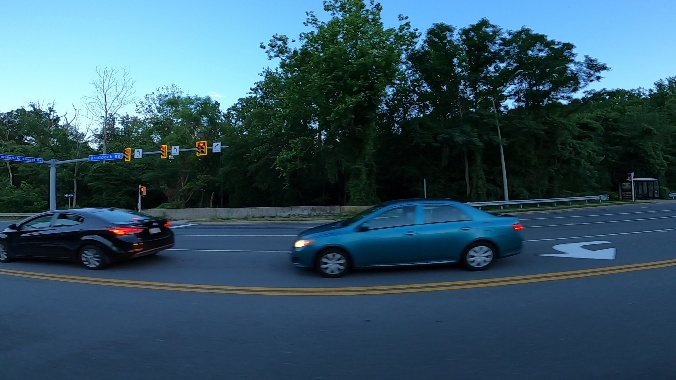

In [7]:
image = random.choice(index)
Image(filename=f'/kaggle/input/car-object-detection/data/training_images/{image}.jpg',width=600)

In [23]:
source = 'training_images'
fold = 0
if True:
    val_index = index[len(index)*fold//5:len(index)*(fold+1)//5]
    for name,mini in tqdm(df.groupby('image_id')):
        if name in val_index:
            path2save = 'val2017/'
        else:
            path2save = 'train2017/'
        if not os.path.exists('/tmp/convertor/fold{}/labels/'.format(fold)+path2save):
            os.makedirs('/tmp/convertor/fold{}/labels/'.format(fold)+path2save)
        with open('/tmp/convertor/fold{}/labels/'.format(fold)+path2save+name+".txt", 'w+') as f:
            row = mini[['classes','x_center','y_center','w','h']].astype(float).values
            row = row.astype(str)
            for j in range(len(row)):
                text = ' '.join(row[j])
                f.write(text)
                f.write("\n")
        if not os.path.exists('/tmp/convertor/fold{}/images/{}'.format(fold,path2save)):
            os.makedirs('/tmp/convertor/fold{}/images/{}'.format(fold,path2save))
        sh.copy("/kaggle/input/car-object-detection/data/{}/{}.jpg".format(source,name),'/tmp/convertor/fold{}/images/{}/{}.jpg'.format(fold,path2save,name))


  0%|          | 0/355 [00:00<?, ?it/s]

In [10]:
!python yolov5/detect.py --weights yolov5/yolov5s.pt --img 676 --conf 0.4 --source /kaggle/input/car-object-detection/data/testing_images

detect: weights=['yolov5/yolov5s.pt'], source=/kaggle/input/car-object-detection/data/testing_images, data=yolov5/data/coco128.yaml, imgsz=[676, 676], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
requirements: /opt/conda/lib/python3.10/site-packages/requirements.txt not found, check failed.
YOLOv5 🚀 v7.0-168-gec2b853 Python-3.10.10 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

100%|██████████████████████████████████████| 14.1M/14.1M [00:00<00:00, 24.8MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
WARNING ⚠️ --img-size [676, 676] must be multiple of max stride 32, updating to [704, 704]
image 1/175 /kaggle/input/car-object-detection/

In [11]:
predicted_files = []
for (dirpath, dirnames, filenames) in os.walk("/kaggle/working/yolov5/runs/detect/exp"):
    predicted_files.extend(filenames)

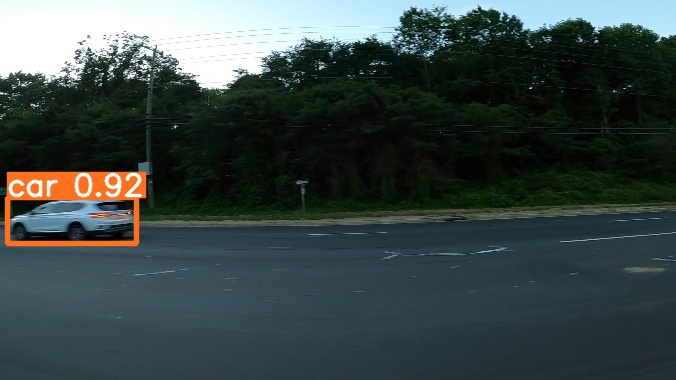

In [12]:
Image(filename=f'/kaggle/working/yolov5/runs/detect/exp/{random.choice(predicted_files)}')

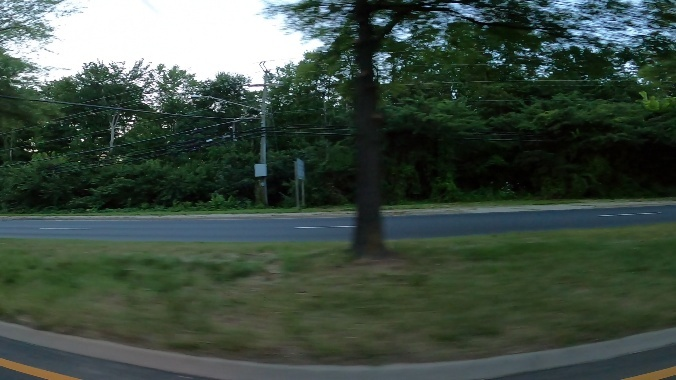

In [13]:
Image(filename=f'/kaggle/working/yolov5/runs/detect/exp/{random.choice(predicted_files)}')

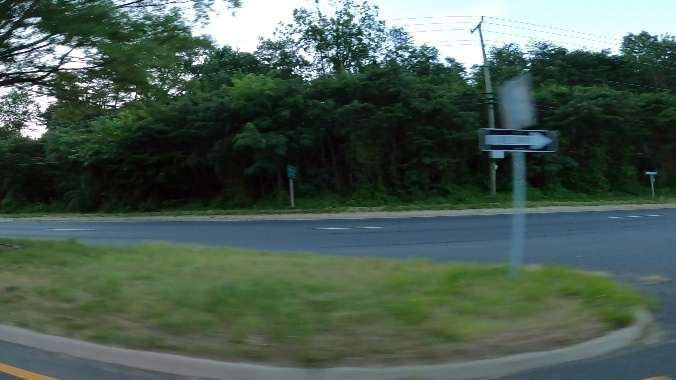

In [14]:
Image(filename=f'/kaggle/working/yolov5/runs/detect/exp/{random.choice(predicted_files)}')


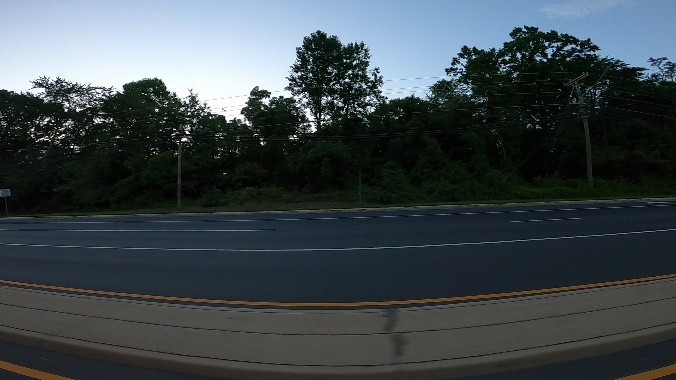

In [15]:
Image(filename=f'/kaggle/working/yolov5/runs/detect/exp/{random.choice(predicted_files)}')


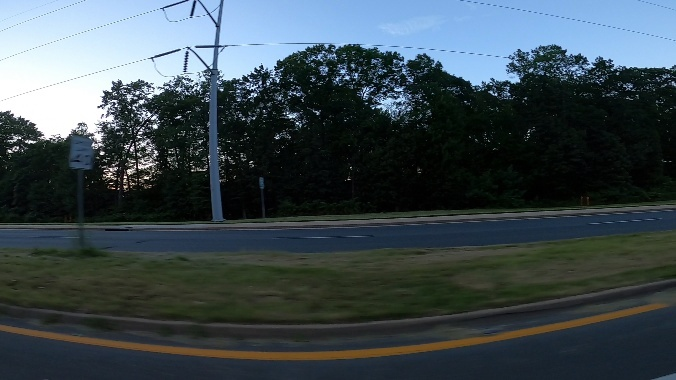

In [16]:
Image(filename=f'/kaggle/working/yolov5/runs/detect/exp/{random.choice(predicted_files)}')

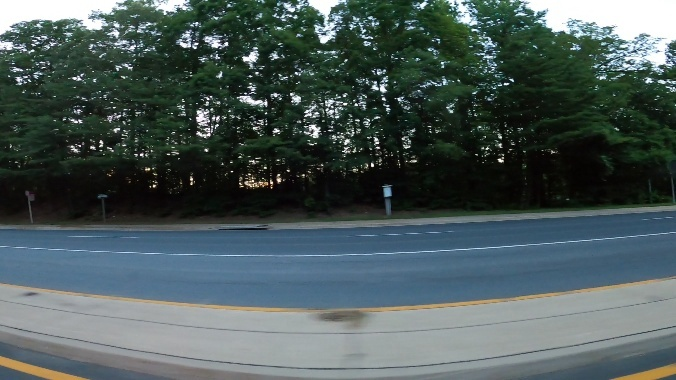

In [17]:
Image(filename=f'/kaggle/working/yolov5/runs/detect/exp/{random.choice(predicted_files)}')


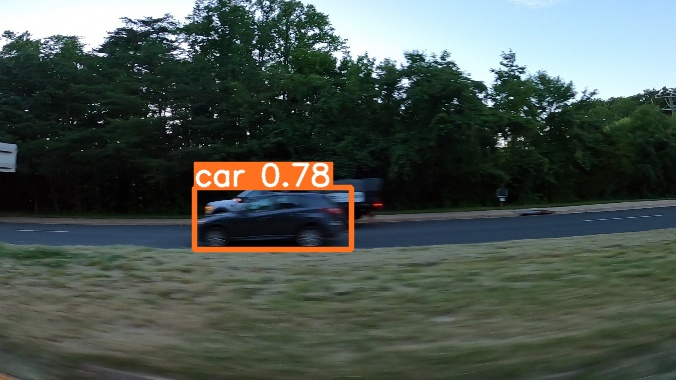

In [18]:
Image(filename=f'/kaggle/working/yolov5/runs/detect/exp/{random.choice(predicted_files)}')

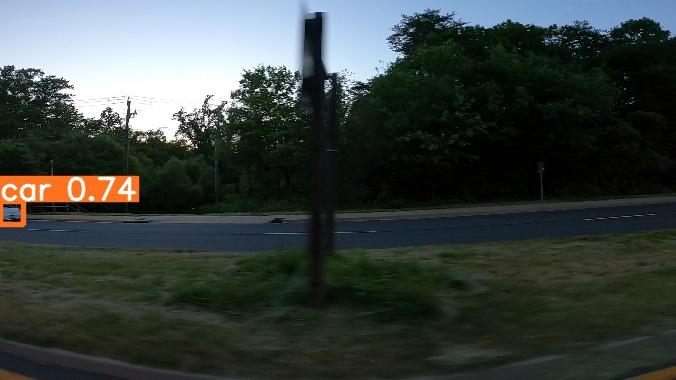

In [19]:
Image(filename=f'/kaggle/working/yolov5/runs/detect/exp/{random.choice(predicted_files)}')

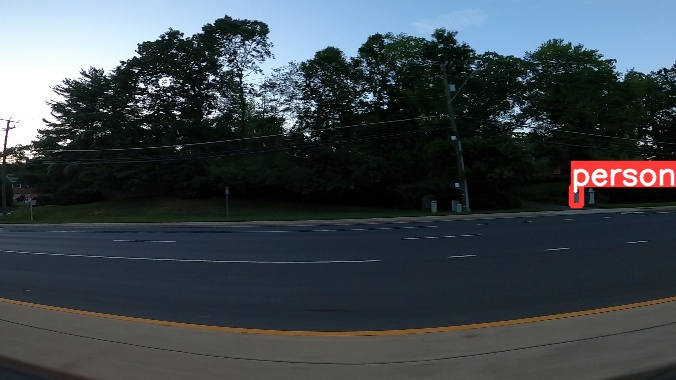

In [20]:
Image(filename=f'/kaggle/working/yolov5/runs/detect/exp/{random.choice(predicted_files)}')

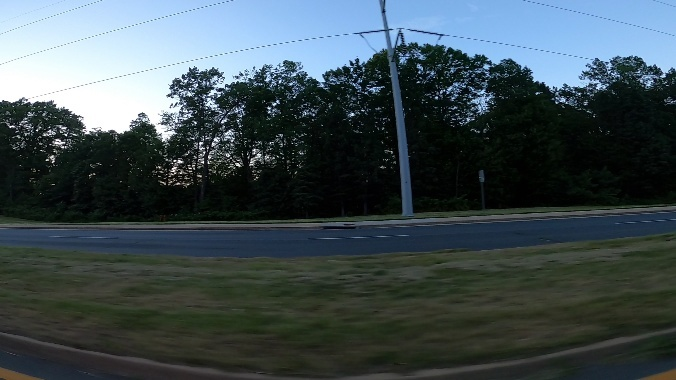

In [21]:
Image(filename=f'/kaggle/working/yolov5/runs/detect/exp/{random.choice(predicted_files)}')

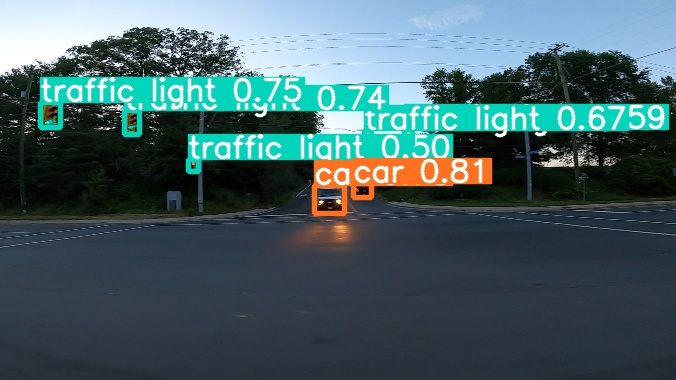

In [22]:
Image(filename=f'/kaggle/working/yolov5/runs/detect/exp/{random.choice(predicted_files)}')